In [0]:
%pip install -U -qqq mlflow[databricks]==3.1.1 langgraph==0.5.4 databricks-langchain==0.6.0 databricks-agents==1.1.0 pydantic<2.12.0 uv
dbutils.library.restartPython()

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


## Workday Sales Support Multi-Agent Framework

 This notebook creates a multi-agent system for sales support with the following components:
  - **Structured Data Agent**: Queries structured sales data (opportunities, accounts, activities)
  - **Vector search Agent**: Retrieves information from unstructured documents (emails, meeting notes, feedback)
  - **Supervisor**: Routes queries to appropriate agents and orchestrates responses


In [0]:
%%writefile agent.py

import functools
import os
from typing import Any, Generator, Literal, Optional

import mlflow
from databricks.sdk import WorkspaceClient
from databricks_langchain import ChatDatabricks, VectorSearchRetrieverTool
from databricks_langchain.genie import GenieAgent
from langchain_core.runnables import RunnableLambda
from langgraph.graph import END, StateGraph
from langgraph.graph.state import CompiledStateGraph
from langgraph.prebuilt import create_react_agent
from mlflow.entities import SpanType
from mlflow.langchain.chat_agent_langgraph import ChatAgentState
from mlflow.pyfunc import ChatAgent
from mlflow.types.agent import (
    ChatAgentChunk,
    ChatAgentMessage,
    ChatAgentResponse,
    ChatContext,
)
from pydantic import BaseModel
import time

w = WorkspaceClient()
token = w.tokens.create(comment=f"sdk-{time.time_ns()}").token_value

# Get catalog and schema from environment or config
CATALOG_NAME = 'smriti_sridhar'
SCHEMA_NAME = 'workday_demos'
GENIE_SPACE_ID = '01f0adf367e51085a8a1ed562fe6a9e8'
MLFLOW_EXPERIMENT_NAME = f'multiagent_genie_{CATALOG_NAME}'
host='https://e2-demo-field-eng.cloud.databricks.com/'

###################################################
## Configure LLM
###################################################
llm = ChatDatabricks(endpoint="databricks-claude-3-7-sonnet")

###################################################
## Create RAG Agent with Vector Search Tools
###################################################

# Create retriever tools for each document type
email_retriever = VectorSearchRetrieverTool(
    index_name=f"{CATALOG_NAME}.{SCHEMA_NAME}.email_communications_index",
    columns=["content", "doc_uri"],
    name="email_search",
    description=(
        "Searches through email communications between sales reps and customers. "
        "Use this to find information about: pricing discussions, objections, "
        "follow-ups, proposal details, and customer email correspondence."
    ),
)

meeting_notes_retriever = VectorSearchRetrieverTool(
    index_name=f"{CATALOG_NAME}.{SCHEMA_NAME}.meeting_notes_index",
    columns=["content", "doc_uri"],
    name="meeting_notes_search",
    description=(
        "Searches through meeting notes and call summaries. "
        "Use this to find information about: customer meetings, demos, "
        "discovery calls, requirements discussions, and decision-maker feedback."
    ),
)

feedback_retriever = VectorSearchRetrieverTool(
    index_name=f"{CATALOG_NAME}.{SCHEMA_NAME}.customer_feedback_index",
    columns=["content", "doc_uri"],
    name="feedback_search",
    description=(
        "Searches through customer feedback and reviews. "
        "Use this to find information about: customer satisfaction, "
        "product impressions, concerns raised, and post-demo feedback."
    ),
)

# Combine all RAG tools
rag_tools = [email_retriever, meeting_notes_retriever, feedback_retriever]

rag_agent_description = (
    "Specializes in retrieving information from unstructured sales documents including "
    "emails, meeting notes, and customer feedback. Use this agent for questions about: "
    "customer communications, meeting discussions, feedback and concerns, proposal details, "
    "and qualitative sales information."
)

rag_agent = create_react_agent(llm, tools=rag_tools)

###################################################
## Create SQL Agent for Structured Data
###################################################

sql_agent_system_prompt = f"""You are a sales data analyst with access to Workday sales CRM data.

Available tables in {CATALOG_NAME}.{SCHEMA_NAME}:
- sales_reps: Information about sales representatives
- customer_accounts: Customer account details and company information
- sales_opportunities: Sales opportunities and deal pipeline
- sales_activities: Sales activities and interactions

When asked about structured data like:
- Sales metrics and KPIs
- Rep performance and quotas
- Customer demographics and firmographics
- Opportunity stages and values
- Activity tracking and history

Provide analytical insights based on the available structured data tables.
"""

genie_description = (
    "Specializes in analyzing structured sales data from CRM tables. "
    "Use this agent for questions about: sales metrics, rep performance, "
    "customer demographics, opportunity pipelines, deal values, quota attainment, "
    "and quantitative sales analytics."
)

genie_agent = GenieAgent(
    genie_space_id=GENIE_SPACE_ID,
    genie_agent_name="Genie",
    description=genie_description,
    client=WorkspaceClient(
        host=host,
        token=token,
    ),
)

#############################
# Define the supervisor agent
#############################

MAX_ITERATIONS = 4

worker_descriptions = {
    "GenieAgent": genie_description,
    "RAGAgent": rag_agent_description,
}

formatted_descriptions = "\n".join(
    f"- {name}: {desc}" for name, desc in worker_descriptions.items()
)

system_prompt = f"""You are a strategic supervisor coordinating between specialized sales support agents.

Your role is to:
1. Analyze the user's question to determine which agent(s) can best answer it
2. Route to the appropriate agent based on the question type
3. Ensure complete answers without redundant work
4. Synthesize information from multiple agents if needed

Available agents:
{formatted_descriptions}

Routing Guidelines:
- Use GenieAgent for: metrics, numbers, quotas, pipeline values, rep performance, account counts, etc.
- Use RAGAgent for: customer communications, meeting context, feedback, concerns, proposals, etc.
- You can route to multiple agents if the question requires both types of information

Only respond with FINISH when:
- The user's question has been fully answered
- All necessary information has been gathered and processed

Avoid routing to the same agent multiple times for the same information.

Important:
- Do not choose FINISH until at least one specialized agent has been invoked.
- Prefer GenieAgent for numeric/metric queries; RAGAgent for unstructured text queries.
"""

options = ["FINISH"] + list(worker_descriptions.keys())
FINISH = {"next_node": "FINISH"}

@mlflow.trace(span_type=SpanType.AGENT, name="supervisor_agent")
def supervisor_agent(state):
    count = state.get("iteration_count", 0) + 1
    
    if count > MAX_ITERATIONS:
        return FINISH
    
    class NextNode(BaseModel):
        next_node: Literal[tuple(options)]

    preprocessor = RunnableLambda(
        lambda state: [{"role": "system", "content": system_prompt}] + state["messages"]
    )
    supervisor_chain = preprocessor | llm.with_structured_output(NextNode)
    result = supervisor_chain.invoke(state)
    next_node = result.next_node
    
    # Prevent routing to the same node consecutively
    if state.get("next_node") == next_node:
        return FINISH
    
    return {
        "iteration_count": count,
        "next_node": next_node
    }

#######################################
# Define multiagent graph structure
#######################################

def agent_node(state, agent, name):
    """Execute agent and return results"""
    # result = agent.invoke(state)
    result = agent.invoke({"messages": state["messages"]})
    return {
        "messages": [
            {
                "role": "assistant",
                "content": result["messages"][-1].content,
                "name": name,
            }
        ]
    }

def final_answer(state):
    """Generate final synthesized answer"""
    prompt = (
        "Based on the information gathered by the specialized agents, "
        "provide a comprehensive answer to the user's question. "
        "Synthesize insights from all agents and present a clear, helpful response."
    )
    preprocessor = RunnableLambda(
        lambda state: state["messages"] + [{"role": "user", "content": prompt}]
    )
    final_answer_chain = preprocessor | llm
    return {"messages": [final_answer_chain.invoke(state)]}

class AgentState(ChatAgentState):
    next_node: str
    iteration_count: int

# Create agent nodes
rag_node = functools.partial(agent_node, agent=rag_agent, name="RAGAgent")
genie_node = functools.partial(agent_node, agent=genie_agent, name="GenieAgent")

# Build the workflow graph
workflow = StateGraph(AgentState)
workflow.add_node("GenieAgent", genie_node)
workflow.add_node("RAGAgent", rag_node)
workflow.add_node("supervisor", supervisor_agent)
workflow.add_node("final_answer", final_answer)

workflow.set_entry_point("supervisor")

# Workers report back to supervisor
for worker in worker_descriptions.keys():
    workflow.add_edge(worker, "supervisor")

# Supervisor decides next node
workflow.add_conditional_edges(
    "supervisor",
    lambda x: x["next_node"],
    {**{k: k for k in worker_descriptions.keys()}, "FINISH": "final_answer"},
)

workflow.add_edge("final_answer", END)
multi_agent = workflow.compile()

###################################
# Wrap in Databricks ChatAgent
###################################

class LangGraphChatAgent(ChatAgent):
    def __init__(self, agent: CompiledStateGraph):
        self.agent = agent

    def predict(
        self,
        messages: list[ChatAgentMessage],
        context: Optional[ChatContext] = None,
        custom_inputs: Optional[dict[str, Any]] = None,
    ) -> ChatAgentResponse:
        request = {
            "messages": [m.model_dump_compat(exclude_none=True) for m in messages]
        }

        messages = []
        for event in self.agent.stream(request, stream_mode="updates"):
            for node_data in event.values():
                messages.extend(
                    ChatAgentMessage(**msg) for msg in node_data.get("messages", [])
                )
        return ChatAgentResponse(messages=messages)

    def predict_stream(
        self,
        messages: list[ChatAgentMessage],
        context: Optional[ChatContext] = None,
        custom_inputs: Optional[dict[str, Any]] = None,
    ) -> Generator[ChatAgentChunk, None, None]:
        request = {
            "messages": [m.model_dump_compat(exclude_none=True) for m in messages]
        }
        for event in self.agent.stream(request, stream_mode="updates"):
            for node_data in event.values():
                yield from (
                    ChatAgentChunk(**{"delta": msg})
                    for msg in node_data.get("messages", [])
                )

# Create the agent
mlflow.langchain.autolog()
AGENT = LangGraphChatAgent(multi_agent)
mlflow.models.set_model(AGENT)

Overwriting agent.py


In [0]:
import os
import mlflow
from agent import *

experiment_fqdn = (
    f"{os.getcwd()}/{MLFLOW_EXPERIMENT_NAME}"
)

# Check if the experiment exists
experiment = mlflow.get_experiment_by_name(experiment_fqdn)

if experiment:
    experiment_id = experiment.experiment_id
else:
    # Create the experiment if it does not exist
    experiment_id = mlflow.create_experiment(experiment_fqdn)

mlflow.set_experiment(experiment_fqdn)

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/4362073218401144', creation_time=1762821705313, experiment_id='4362073218401144', last_update_time=1762821705313, lifecycle_stage='active', name=('/Users/smriti.sridhar@databricks.com/Workday-demos/multi-agent/Blog '
 'Notebooks/multiagent_genie_smriti_sridhar'), tags={'mlflow.experiment.sourceName': '/Users/smriti.sridhar@databricks.com/Workday-demos/multi-agent/Blog '
                                 'Notebooks/multiagent_genie_smriti_sridhar',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'smriti.sridhar@databricks.com',
 'mlflow.ownerId': '7742533985527510'}>

Trace(trace_id=tr-82b82dc1164121bff81e8ffee32fcadf)

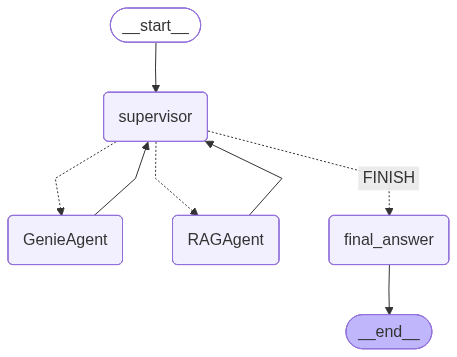

In [0]:
from IPython.display import Image, display

display(Image(AGENT.agent.get_graph().draw_mermaid_png()))

%md

### Test the LangGraph Agent

In [0]:
sample_questions = [
    "How many outbound emails were sent by each sales rep last quarter?",
    "Summarize the main concerns customers raised about implementation delays.",
    "Extract any customer feedback that praises response time or support quality."
]

input_example = {
    "messages": [
        {
            "role": "user",
            "content": sample_questions[0],
        }
    ]
}

In [0]:
response = AGENT.predict(input_example)

Trace(trace_id=tr-3e479b4360e4e51b53b9e83e2deb9717)

In [0]:
print("### FINAL RESPONSE:")
print(response.messages[-1].content)

### FINAL RESPONSE:
# Outbound Emails by Sales Representatives - Last Quarter

The data shows the number of outbound emails sent by each sales representative during the last quarter. Here's a summary of the findings:

## Key Observations:
- Daniel Robinson (REP0027) sent the most emails with 20
- James Jackson (REP0028) was second with 18 emails
- Susan Davis (REP0055) was third with 17 emails
- The top 5 is rounded out by Susan Thomas (16) and Nancy Garcia (15)

## Distribution:
- 3 reps sent 17+ emails
- 12 reps sent 13-16 emails
- 21 reps sent 10-12 emails
- 39 reps sent fewer than 10 emails
- The lowest count was Jason Jones (REP0042) with just 1 email

This data could help identify high-performing reps in terms of outreach activity as well as those who might need encouragement to increase their email communications.


In [0]:
rag_out = rag_agent.invoke({"messages": [{"role":"user","content":"Summarize complaints about implementation delays"}]})
print(rag_out["messages"][-1].content)

[NOTICE] Using a notebook authentication token. Recommended for development only. For improved performance, please use Service Principal based authentication. To disable this message, pass disable_notice=True.
[NOTICE] Using a notebook authentication token. Recommended for development only. For improved performance, please use Service Principal based authentication. To disable this message, pass disable_notice=True.
[NOTICE] Using a notebook authentication token. Recommended for development only. For improved performance, please use Service Principal based authentication. To disable this message, pass disable_notice=True.
[NOTICE] Using a notebook authentication token. Recommended for development only. For improved performance, please use Service Principal based authentication. To disable this message, pass disable_notice=True.
I'm not able to retrieve specific information about implementation delays from the available knowledge bases. To provide you with a summary of complaints about 

Trace(trace_id=tr-a438ad0d7f9276569b43eacba2134d16)

In [0]:
genie_out = genie_agent.invoke({"messages": [{"role":"user","content":"Total pipeline value by stage last quarter"}]})
print(genie_out["messages"][-1].content)

|    | SalesStage   |   TotalPipelineValue |
|---:|:-------------|---------------------:|
|  0 | Closed Lost  |             67440304 |
|  1 | Closed Won   |            106524416 |


Trace(trace_id=tr-66b02aa2b32cfb45866ea58202b7473b)

%md

### Log into MLFlow

In [0]:
# Determine Databricks resources to specify for automatic auth passthrough at deployment time
import mlflow
from pkg_resources import get_distribution
from databricks_langchain import UnityCatalogTool, VectorSearchRetrieverTool
from mlflow.models.resources import (
    DatabricksFunction,
    DatabricksGenieSpace,
    DatabricksServingEndpoint,
    DatabricksVectorSearchIndex,
    DatabricksSQLWarehouse,
    DatabricksTable,
)

resources = [
    DatabricksServingEndpoint(endpoint_name="databricks-claude-3-7-sonnet"),
    DatabricksGenieSpace(genie_space_id=GENIE_SPACE_ID),
    DatabricksSQLWarehouse(warehouse_id='4b9b953939869799'),
]

# for tool in tools:
#     if isinstance(tool, VectorSearchRetrieverTool):
#         resources.extend(tool.resources)
#     elif isinstance(tool, UnityCatalogTool):
#         resources.append(DatabricksFunction(function_name=tool.uc_function_name))

with mlflow.start_run():
    logged_agent_info = mlflow.pyfunc.log_model(
        name=f"multi_agent_at",
        python_model="agent.py",
        # model_config=os.path.join(os.getcwd(), "00-init-requirements"),
        input_example=input_example,
        resources=resources,
        pip_requirements=[
            f"databricks-connect=={get_distribution('databricks-connect').version}",
            f"mlflow=={get_distribution('mlflow').version}",
            f"databricks-langchain=={get_distribution('databricks-langchain').version}",
            f"langgraph=={get_distribution('langgraph').version}",
        ]
    )

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/4362073218401144/models/m-d0930b6325664f61a1ef9c6bad34c58f?o=1444828305810485
2025/11/11 00:46:57 INFO mlflow.pyfunc: Predicting on input example to validate output



### Local Validation

In [0]:
input_example = {
  'messages': [
          {'role': 'user',
           'content': 'provide a summary of what do our policies say about customers eligible for promotions but receiving poor service?'
           }
          ]
    }
   
response = mlflow.models.predict(
    model_uri=f"runs:/{logged_agent_info.run_id}/multi_agent_at",
    input_data=input_example,
    env_manager="uv",
)

2025/11/11 00:49:01 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'


2025/11/11 00:49:03 INFO mlflow.utils.virtualenv: Creating a new environment in /tmp/virtualenv_envs/mlflow-afafd2d71efcc7256d11974615d155b503dd582c with python version 3.11.10 using uv
Using CPython 3.11.10 interpreter at: /usr/bin/python3.11
Creating virtual environment at: /tmp/virtualenv_envs/mlflow-afafd2d71efcc7256d11974615d155b503dd582c
Activate with: source /tmp/virtualenv_envs/mlflow-afafd2d71efcc7256d11974615d155b503dd582c/bin/activate
2025/11/11 00:49:05 INFO mlflow.utils.virtualenv: Installing dependencies
Using Python 3.11.10 environment at: /tmp/virtualenv_envs/mlflow-afafd2d71efcc7256d11974615d155b503dd582c
Resolved 3 packages in 93ms
Prepared 3 packages in 132ms
Installed 3 packages in 22ms
 + pip==24.2
 + setuptools==75.1.0
 + wheel==0.38.4
Using Python 3.11.10 environment at: /tmp/virtualenv_envs/mlflow-afafd2d71efcc7256d11974615d155b503dd582c
Resolved 124 packages in 975ms
Prepared 123 packages in 3.72s
Installed 123 packages in 276ms
 + aiohappyeyeballs==2.6.1
 + ai

[NOTICE] Using a notebook authentication token. Recommended for development only. For improved performance, please use Service Principal based authentication. To disable this message, pass disable_notice=True.
[NOTICE] Using a notebook authentication token. Recommended for development only. For improved performance, please use Service Principal based authentication. To disable this message, pass disable_notice=True.
[NOTICE] Using a notebook authentication token. Recommended for development only. For improved performance, please use Service Principal based authentication. To disable this message, pass disable_notice=True.
[NOTICE] Using a notebook authentication token. Recommended for development only. For improved performance, please use Service Principal based authentication. To disable this message, pass disable_notice=True.
[NOTICE] Using a notebook authentication token. Recommended for development only. For improved performance, please use Service Principal based authentication. T

2025/11/11 00:49:42 INFO mlflow.tracing.export.async_export_queue: Flushing the async trace logging queue before program exit. This may take a while...



### Register Model

In [0]:
mlflow.set_registry_uri("databricks-uc")

# Define the catalog, schema, and model name for your UC model
catalog = catalog_name
schema = schema_name
model_name = f"multi_agent_demo_{catalog_name}"
UC_MODEL_NAME = f"{catalog}.{schema}.{model_name}"

# register the model to UC
uc_registered_model_info = mlflow.register_model(
    model_uri=logged_agent_info.model_uri, name=UC_MODEL_NAME
)


### Create Endpoint

In [0]:
from databricks import agents

agents.deploy(
    UC_MODEL_NAME,
    uc_registered_model_info.version,
    tags={"endpointSource": "playground"},
    endpoint_name = f"multi_agent_{catalog_name}",
    environment_vars={
        "DATABRICKS_GENIE_PAT": token
    },
)